In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import torch
# import ot
from misc.torchot import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import itertools
dev = torch.device('cuda')

In [2]:
# plt.rc('text', usetex=True)
# plt.rc('font',**{'family':'cmr10','serif':['Computer Modern Roman'],'size':'8'})
# plt.rc('axes.formatter', use_mathtext=True)
# centm=1/2.54

In [3]:
def getDistSqrTorus(x,y):
    dim = 1
    if (x.ndim == 2):
        dim = x.shape[1]
    m = x.shape[0]
    n = y.shape[0]
    return torch.sum(((x.reshape((m,1,dim))-y.reshape((1,n,dim)) + 0.5)%1 - 0.5)**2, dim = 2)

def cost(X,Y):
    
    return getDistSqrTorus(X,Y)

In [4]:
def dens_gauss_shift(X, Y, shift, std, shift_prob=0.5):
    """
    X, Y same shape numpy arrays to describe point clouds
    shift = shift of second diagonal
    std = standard deviation of both diagonals
    shift_prob = probability of going to the se
    """
    
    o = torch.ceil(torch.tensor(4 * std).to(dev))
    
    a = (Y - X).reshape((*X.shape, 1))
    z = torch.arange(-o, o+1, dtype=float, device = dev).reshape((*[1 for _ in X.shape], -1))
    
    d0 = 1 / ((2 * torch.pi)**.5 * std) * torch.sum(torch.exp(-(a - z)**2 / (2 * std**2)), axis=-1)
    d1 = 1 / ((2 * torch.pi)**.5 * std) * torch.sum(torch.exp(-(a - shift - z)**2 / (2 * std**2)), axis=-1)
    
    return shift_prob * d1 + (1 - shift_prob) * d0

In [5]:
def sample_Gau(gen,num ,std, shift,dim = 1, shift_prob = 0.5):
    x = gen.random(num)
    shift_ind = gen.choice([0,1], p=[1-shift_prob,shift_prob],size = num)
    gau = gen.normal(0, std, size = num)
    y = x + shift_ind*shift + gau
    y = y%1
    if(dim == 1):
        return torch.tensor(x.T).to(dev)[:,None],torch.tensor(y.T).to(dev)[:,None]
    while (dim > 1):
        xx = gen.random(num)
        yy = gen.random(num)
        x = np.vstack((x, xx))
        y = np.vstack((y, yy))
        dim -= 1
    return torch.tensor(x.T).to(dev),torch.tensor(y.T).to(dev)

In [9]:
# epsL = torch.tensor([.01, .0025, .001], device = dev)
# epsL = torch.tensor([.01, .0025, .001], device = dev)
# Nlist = np.unique(np.logspace(0,3.5,100, dtype=int))
# stdL = [.01]
# shift = 1/3
# dim = 3
# shift_prob = .5
# n_sim = 500
# N_sim = 100
def get_torus_simulation(gen, Nlist, stdL, epsL, shift, shift_prob, dim, N_sim = 100, n_sim = 500):
    df = []
    epsL = torch.sort(torch.tensor(epsL, device = dev), descending = True)[0]
    for N, std in tqdm(list(itertools.product(Nlist, stdL))):
        b = np.clip(1e10/(2*8*N**2), 1, N_sim).astype(int)
        sta_ptr = np.arange(0,N_sim, b, dtype=int)
        for ii in sta_ptr:
            bb = min(b, N_sim - ii)
            costXXL = []
            costYYL = []
            xL = []
            yL = []
            for _ in range(bb):
                x,y = sample_Gau(gen = gen, num = N, std = std, shift = shift, dim=dim, shift_prob=shift_prob)
                xL.append(x)
                yL.append(y)
                costXXL.append(cost(x,x))
                costYYL.append(cost(y,y))

            costXXL = torch.stack(costXXL).cpu()
            costYYL = torch.stack(costYYL).cpu()
            xL = torch.stack(xL)
            yL = torch.stack(yL)
            _, _, betaX = SolveEOT(costXXL.to(dev), epsL)
            _, alphaY, _ = SolveEOT(costYYL.to(dev), epsL)


            ePts = 200
            res_mcmc = []
            res_mcmc2 = []
            for _ in range(n_sim):
                x_e = torch.rand(size = (ePts, dim), device = dev)
                y_e = torch.rand(size = (ePts, dim), device = dev)
                costX = torch.stack([cost(x_e,xL[i]) for i in range(xL.shape[0])])
                costY = torch.stack([cost(y_e,yL[i]) for i in range(xL.shape[0])])
                pot_x = -epsL[None,:,None] * (torch.logsumexp((-costX[:,None,...] + betaX[:,:,None,:])/epsL[None,:,None,None], dim = -1) - torch.log(torch.tensor(N,device = dev))) 
                pot_y = -epsL[None,:,None] * (torch.logsumexp((-costY[:,None,...] + alphaY[:,:,None,:])/epsL[None,:,None,None], dim = -1) - torch.log(torch.tensor(N,device = dev))) 
                KX = torch.exp((-costX[:,None,...] + betaX[...,None,:] + pot_x[...,None])/epsL[None,:,None,None])
                KY = torch.exp((-costY[:,None,...] + alphaY[...,None,:] + pot_y[...,None])/epsL[None,:,None,None]).permute(0,1,3,2)
                Res = (KX@KY/N).permute(0,1,3,2)
                xgrid, ygrid = torch.meshgrid(x_e[:,0], y_e[:,0], indexing='xy')
                dens = dens_gauss_shift(xgrid, ygrid, shift, std, shift_prob)
                dens2 = []
                for e in epsL:
                    dens2.append(dens_gauss_shift(xgrid, ygrid, shift, (std**2 + e)**.5, shift_prob))
                dens2 = torch.stack(dens2)
                interres = ((Res - dens[None,None,:,:])**2).mean([2,3])
                interres2 = ((Res - dens2[None,...])**2).mean([2,3])
                res_mcmc.append(interres.cpu())
                res_mcmc2.append(interres2.cpu())
            otpt = torch.stack(res_mcmc).mean(0)**.5 #b,3
            otpt2 = torch.stack(res_mcmc2).mean(0)**.5 #b,3
            
            for i, sig in enumerate(epsL):
                df.append(pd.DataFrame({'N' : N, 'dim' : dim, 'std' : std, 'shift' : shift, 'shift_prob' : shift_prob , 'sigma' : sig.item(), 'L2_1' : otpt[:,i], 'L2_2' : otpt2[:,i]}))
    return pd.concat(df)

In [8]:
seed = np.random.SeedSequence()
gen = np.random.Generator(np.random.MT19937(seed))
get_torus_simulation(gen, [50,100],
                     [.1,.2],
                     [.01,.03], 1/3, .5, 1, N_sim = 20)

  0%|          | 0/4 [00:00<?, ?it/s]/local/jobs/u12153_11243058/ipykernel_1624672/2729149654.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  o = torch.ceil(torch.tensor(4 * std).to(dev))
100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


,N,dim,std,shift,shift_prob,sigma,L2_1,L2_2
0,50,1,0.1,0.333333,0.5,0.03,0.483782,0.156161
1,50,1,0.1,0.333333,0.5,0.03,0.490704,0.169728
2,50,1,0.1,0.333333,0.5,0.03,0.508227,0.130132
3,50,1,0.1,0.333333,0.5,0.03,0.480561,0.157894
4,50,1,0.1,0.333333,0.5,0.03,0.514272,0.227531
...,...,...,...,...,...,...,...,...
15,100,1,0.2,0.333333,0.5,0.01,0.378485,0.347592
16,100,1,0.2,0.333333,0.5,0.01,0.304762,0.297939
17,100,1,0.2,0.333333,0.5,0.01,0.247877,0.236344
18,100,1,0.2,0.333333,0.5,0.01,0.412349,0.427033


In [7]:
seed = np.random.SeedSequence()
gen = np.random.Generator(np.random.MT19937(seed))

In [8]:
N = 3000
std = .1
shift = 1/3
dim = 2
shift_prob = .5
# x,y = sample_Gau(gen = gen, num = N, std = std, shift = shift, dim=dim, shift_prob=0.5)


In [7]:
costXXL = []
costYYL = []
xL = []
yL = []
for _ in range(100):
    x,y = sample_Gau(gen = gen, num = N, std = std, shift = shift, dim=dim, shift_prob=shift_prob)
    xL.append(x)
    yL.append(y)
    costXXL.append(cost(x,x))
    costYYL.append(cost(y,y))

In [8]:
costXXL = torch.stack(costXXL)
costYYL = torch.stack(costYYL)
xL = torch.stack(xL)
yL = torch.stack(yL)

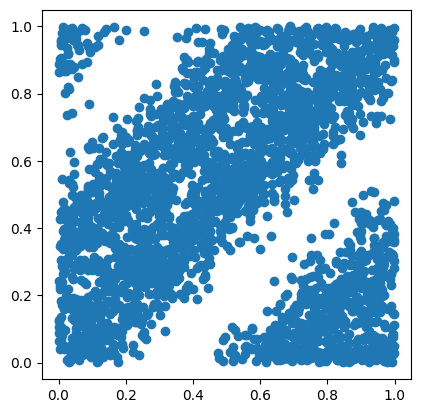

In [9]:
plt.scatter(x[:,0].cpu(), y[:,0].cpu())
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.gca().set_aspect('equal')

In [ ]:
# x,y = torch.meshgrid(torch.linspace(0,1,100, device=dev),torch.linspace(0,1,100, device=dev), indexing='xy')


In [12]:
np.unique(np.logspace(0,3.5,100, dtype=int))

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   17,   18,   20,   22,   23,   25,   28,
         30,   33,   35,   38,   42,   45,   49,   53,   58,   63,   68,
         74,   81,   87,   95,  103,  112,  121,  132,  143,  155,  168,
        183,  198,  215,  233,  253,  275,  298,  323,  351,  380,  413,
        448,  486,  527,  572,  620,  673,  730,  792,  859,  932, 1011,
       1097, 1190, 1291, 1401, 1519, 1648, 1788, 1940, 2104, 2283, 2477,
       2687, 2915, 3162])

In [63]:
epsL = torch.tensor([.01, .0025, .001], device = dev)
std = .01
shift = 1/3
dim = 1
shift_prob = .5
df = []
for N in tqdm(Nlist):
    costXXL = []
    costYYL = []
    xL = []
    yL = []
    for _ in range(100):
        x,y = sample_Gau(gen = gen, num = N, std = std, shift = shift, dim=dim, shift_prob=shift_prob)
        xL.append(x)
        yL.append(y)
        costXXL.append(cost(x,x))
        costYYL.append(cost(y,y))

    costXXL = torch.stack(costXXL)
    costYYL = torch.stack(costYYL)
    xL = torch.stack(xL)
    yL = torch.stack(yL)
    CostX, alphaX, betaX = SolveEOT(costXXL, epsL)
    CostY, alphaY, betaY = SolveEOT(costYYL, epsL)


    ePts = 200
    res_mcmc = []
    res_mcmc2 = []
    for _ in range(500):
        x_e = torch.rand(size = (ePts, dim), device = dev)
        y_e = torch.rand(size = (ePts, dim), device = dev)
        costX = torch.stack([cost(x_e,xL[i]) for i in range(xL.shape[0])])
        costY = torch.stack([cost(y_e,yL[i]) for i in range(xL.shape[0])])
        pot_x = -epsL[None,:,None] * (torch.logsumexp((-costX[:,None,...] + betaX[:,:,None,:])/epsL[None,:,None,None], dim = -1) - torch.log(torch.tensor(N,device = dev))) 
        pot_y = -epsL[None,:,None] * (torch.logsumexp((-costY[:,None,...] + alphaY[:,:,None,:])/epsL[None,:,None,None], dim = -1) - torch.log(torch.tensor(N,device = dev))) 
        KX = torch.exp((-costX[:,None,...] + betaX[...,None,:] + pot_x[...,None])/epsL[None,:,None,None])
        KY = torch.exp((-costY[:,None,...] + alphaY[...,None,:] + pot_y[...,None])/epsL[None,:,None,None]).permute(0,1,3,2)
        Res = (KX@KY/N).permute(0,1,3,2)
        xgrid, ygrid = torch.meshgrid(x_e[:,0], y_e[:,0], indexing='xy')
        dens = dens_gauss_shift(xgrid, ygrid, shift, std, shift_prob)
        # dens2 = dens_gauss_shift(xgrid, ygrid, shift, np.sqrt(std**2 + ve), shift_prob)
        dens2 = []
        for e in epsL:
            dens2.append(dens_gauss_shift(xgrid, ygrid, shift, (std**2 + e)**.5, shift_prob))
        dens2 = torch.stack(dens2)
        interres = ((Res - dens[None,None,:,:])**2).mean([2,3])
        interres2 = ((Res - dens2[None,...])**2).mean([2,3])
        res_mcmc.append(interres.cpu())
        res_mcmc2.append(interres2.cpu())
    otpt = torch.stack(res_mcmc).mean(0)**.5 #100,3
    otpt2 = torch.stack(res_mcmc2).mean(0)**.5 #100,3
    
    for i, sig in enumerate(epsL):
        df.append(pd.DataFrame({'N' : N, 'dim' : dim, 'std' : std, 'shift' : shift, 'shift_prob' : shift_prob , 'sigma' : sig.item(), 'L2_1' : otpt[:,i], 'L2_2' : otpt2[:,i]}))
myD = pd.concat(df)


  0%|          | 0/44 [00:00<?, ?it/s]/local/jobs/u12153_10915464/ipykernel_287960/2729149654.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  o = torch.ceil(torch.tensor(4 * std).to(dev))
100%|██████████| 44/44 [12:30<00:00, 17.06s/it]


In [30]:
Nlist = np.unique(np.logspace(0,4,30, dtype=int))
Nlist

array([    1,     2,     3,     4,     6,     9,    12,    17,    23,
          32,    45,    62,    85,   117,   161,   221,   303,   417,
         573,   788,  1082,  1487,  2043,  2807,  3856,  5298,  7278,
       10000])

In [ ]:
N = 7000
b = np.clip(1e10/(8*N**2), 1, 100).astype(int)
sta_ptr = np.arange(0,100, b, dtype=int)

25

In [20]:
sta_ptr = np.arange(0,100, b, dtype=int)

In [25]:
100 - sta_ptr

array([100,  75,  50,  25])

In [38]:
# epsL = torch.tensor([.01, .0025, .001], device = dev)
epsL = torch.tensor([.01, .0025, .001], device = dev)
# std = .01
shift = 1/3
dim = 3
shift_prob = .5
df = []
for N, std in tqdm(list(itertools.product(Nlist, [.01]))):
    b = np.clip(1e10/(2*8*N**2), 1, 100).astype(int)
    sta_ptr = np.arange(0,100, b, dtype=int)
    for ii in sta_ptr:
        bb = min(b, 100 - ii)
        costXXL = []
        costYYL = []
        xL = []
        yL = []
        for _ in range(bb):
            x,y = sample_Gau(gen = gen, num = N, std = std, shift = shift, dim=dim, shift_prob=shift_prob)
            xL.append(x)
            yL.append(y)
            costXXL.append(cost(x,x))
            costYYL.append(cost(y,y))

        costXXL = torch.stack(costXXL).cpu()
        costYYL = torch.stack(costYYL).cpu()
        xL = torch.stack(xL)
        yL = torch.stack(yL)
        CostX, alphaX, betaX = SolveEOT(costXXL.to(dev), epsL)
        CostY, alphaY, betaY = SolveEOT(costYYL.to(dev), epsL)


        ePts = 200
        res_mcmc = []
        res_mcmc2 = []
        for _ in range(500):
            x_e = torch.rand(size = (ePts, dim), device = dev)
            y_e = torch.rand(size = (ePts, dim), device = dev)
            costX = torch.stack([cost(x_e,xL[i]) for i in range(xL.shape[0])])
            costY = torch.stack([cost(y_e,yL[i]) for i in range(xL.shape[0])])
            pot_x = -epsL[None,:,None] * (torch.logsumexp((-costX[:,None,...] + betaX[:,:,None,:])/epsL[None,:,None,None], dim = -1) - torch.log(torch.tensor(N,device = dev))) 
            pot_y = -epsL[None,:,None] * (torch.logsumexp((-costY[:,None,...] + alphaY[:,:,None,:])/epsL[None,:,None,None], dim = -1) - torch.log(torch.tensor(N,device = dev))) 
            KX = torch.exp((-costX[:,None,...] + betaX[...,None,:] + pot_x[...,None])/epsL[None,:,None,None])
            KY = torch.exp((-costY[:,None,...] + alphaY[...,None,:] + pot_y[...,None])/epsL[None,:,None,None]).permute(0,1,3,2)
            Res = (KX@KY/N).permute(0,1,3,2)
            xgrid, ygrid = torch.meshgrid(x_e[:,0], y_e[:,0], indexing='xy')
            dens = dens_gauss_shift(xgrid, ygrid, shift, std, shift_prob)
            # dens2 = dens_gauss_shift(xgrid, ygrid, shift, np.sqrt(std**2 + ve), shift_prob)
            dens2 = []
            for e in epsL:
                dens2.append(dens_gauss_shift(xgrid, ygrid, shift, (std**2 + e)**.5, shift_prob))
            dens2 = torch.stack(dens2)
            interres = ((Res - dens[None,None,:,:])**2).mean([2,3])
            interres2 = ((Res - dens2[None,...])**2).mean([2,3])
            res_mcmc.append(interres.cpu())
            res_mcmc2.append(interres2.cpu())
        otpt = torch.stack(res_mcmc).mean(0)**.5 #b,3
        otpt2 = torch.stack(res_mcmc2).mean(0)**.5 #b,3
        
        for i, sig in enumerate(epsL):
            df.append(pd.DataFrame({'N' : N, 'dim' : dim, 'std' : std, 'shift' : shift, 'shift_prob' : shift_prob , 'sigma' : sig.item(), 'L2_1' : otpt[:,i], 'L2_2' : otpt2[:,i]}))
myD = pd.concat(df)

  0%|          | 0/28 [00:00<?, ?it/s]/local/jobs/u12153_10966247/ipykernel_483425/2729149654.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  o = torch.ceil(torch.tensor(4 * std).to(dev))
100%|██████████| 28/28 [20:58<00:00, 44.94s/it] 


In [39]:
myDD = pd.concat([myD1, myD2, myD])

In [78]:
myDD.to_csv('/user/bi/u12153/OTO/dim_data.csv', index=False)

In [77]:

g = sns.relplot(myDD,x = 'N', y = 'L2_2', hue = 'dim', col = 'sigma',kind = 'line',legend = 'full',palette = 'tab10')
# ax.set(xscale = 'log')
# ax.set(yscale = 'log')
# ax.spines['right'].set_visible(True)
# ax.spines['top'].set_visible(True)
for ax in g.axes.flat:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.spines['right'].set_visible(True) 
    ax.spines['top'].set_visible(True)
g.axes.flat[0].set_ylabel("$||t^\\varepsilon - t^\\varepsilon_N||_{L^2(\mu\otimes\\nu)}$")
g.axes.flat[0].set_title('$\\varepsilon = 0.001$')
g.axes.flat[1].set_title('$\\varepsilon = 0.0025$')
g.axes.flat[2].set_title('$\\varepsilon = 0.01$')
g._legend.set_bbox_to_anchor((0.96, 0.8)) 



RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x152d6574e980> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1500x500 with 3 Axes>

In [51]:
g.axes.flat[0]

<Axes: title={'center': 'sigma = 0.0010000000474974513'}, xlabel='N', ylabel='L2_2'>

In [ ]:
# myD2 = myD.copy()

In [41]:
myDD.to_csv('./OTO/Torus_data_multi_dim.csv', index=False)

In [77]:
D1 = pd.read_csv('./OTO/Torus_data_1.csv')
D2 = pd.read_csv('./OTO/Torus_data_2.csv')

In [79]:
myD = pd.concat([D1,D2])
myD

,N,dim,std,shift,shift_prob,sigma,L2_1,L2_2
0,1,1,0.01,0.333333,0.5,0.010,3.622027,0.702322
1,1,1,0.01,0.333333,0.5,0.010,3.622027,0.702322
2,1,1,0.01,0.333333,0.5,0.010,3.622027,0.702322
3,1,1,0.01,0.333333,0.5,0.010,3.622027,0.702322
4,1,1,0.01,0.333333,0.5,0.010,3.622027,0.702322
...,...,...,...,...,...,...,...,...
13195,3162,1,0.20,0.333333,0.5,0.001,0.202595,0.202379
13196,3162,1,0.20,0.333333,0.5,0.001,0.206164,0.206138
13197,3162,1,0.20,0.333333,0.5,0.001,0.196141,0.196694
13198,3162,1,0.20,0.333333,0.5,0.001,0.214482,0.214346


In [80]:
myD.to_csv('./OTO/Torus_data_all.csv', index=False)

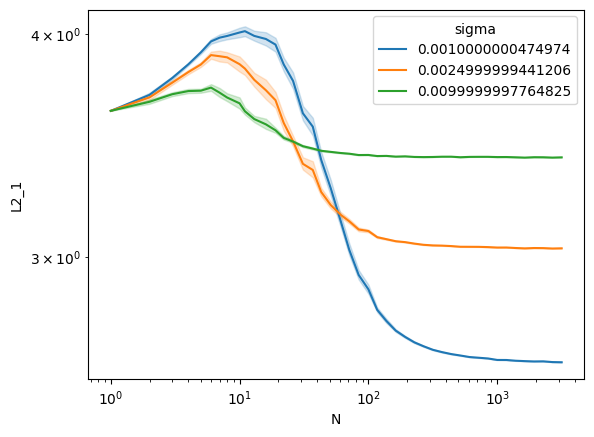

In [82]:
sns.lineplot(data=myD[myD['std'] == .01], x = 'N', y = 'L2_1', hue = 'sigma',palette= 'tab10')
plt.xscale('log')
plt.yscale('log')

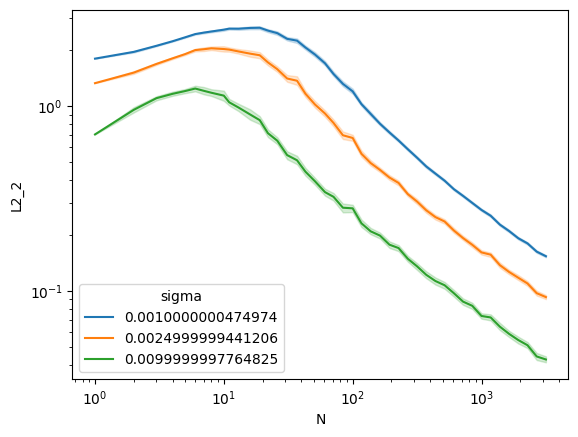

In [ ]:
sns.lineplot(data=myD[myD['sigma'] == .01], x = 'N', y = 'L2_2', hue = 'sigma',palette= 'tab10')
plt.xscale('log')
plt.yscale('log')

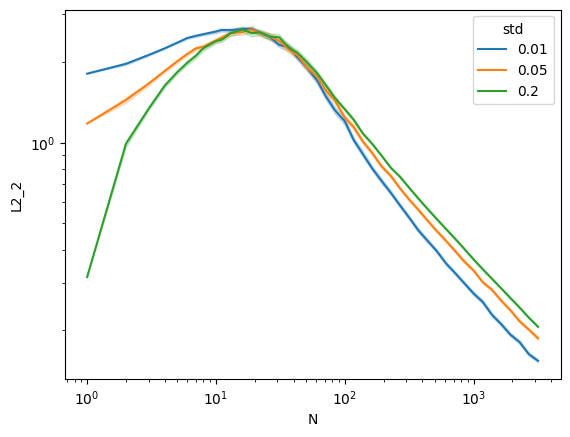

In [88]:
sns.lineplot(data=myD[myD['sigma'] <= .00101], x = 'N', y = 'L2_2', hue = 'std',palette= 'tab10')
plt.xscale('log')
plt.yscale('log')

In [46]:
otpt = torch.stack(res_mcmc).mean(0)**.5 #100,3
df = []
for i, sig in enumerate(epsL):
    df.append(pd.DataFrame({'N' : N, 'dim' : dim, 'std' : std, 'shift' : shift, 'shift_prob' : shift_prob , 'sigma' : sig.item(), 'L2' : otpt[:,i]}))
myD = pd.concat(df)
myD

,N,dim,std,shift,shift_prob,sigma,L2
0,3000,2,0.01,0.333333,0.5,0.010,0.659314
1,3000,2,0.01,0.333333,0.5,0.010,0.656305
2,3000,2,0.01,0.333333,0.5,0.010,0.660917
3,3000,2,0.01,0.333333,0.5,0.010,0.666235
4,3000,2,0.01,0.333333,0.5,0.010,0.661236
...,...,...,...,...,...,...,...
95,3000,2,0.01,0.333333,0.5,0.001,3.443156
96,3000,2,0.01,0.333333,0.5,0.001,3.455946
97,3000,2,0.01,0.333333,0.5,0.001,3.456672
98,3000,2,0.01,0.333333,0.5,0.001,3.458670


In [35]:
F0 = pd.DataFrame({'N' : N, 'std' : .01, 'L2' : otpt[:,0]})
F1 = pd.DataFrame({'N' : N, 'std' : .0025, 'L2' : otpt[:,1]})
F2 = pd.DataFrame({'N' : N, 'std' : .001, 'L2' : otpt[:,2]})
myD = pd.concat([F0,F1,F2])
myD

,N,std,L2
0,3000,0.010,0.473902
1,3000,0.010,0.478578
2,3000,0.010,0.463497
3,3000,0.010,0.476860
4,3000,0.010,0.480835
...,...,...,...
95,3000,0.001,3.091270
96,3000,0.001,3.076858
97,3000,0.001,3.079584
98,3000,0.001,3.076707


In [ ]:
#take uniform grid 

# x_e = torch.rand_like(xL[0], device = dev)
# y_e = torch.rand_like(yL[0], device = dev)
# x_e = torch.linspace(0,1,ePts,device = dev)[:,None]
# y_e = torch.linspace(0,1,ePts,device = dev)[:,None]
x_e = torch.rand(size = (ePts, dim), device = dev)
y_e = torch.rand(size = (ePts, dim), device = dev)
# x_e = torch.linspace(0,1,ePts,device = dev)[:,None]
# y_e = torch.linspace(0,1,ePts,device = dev)[:,None]

In [237]:
costX = torch.stack([cost(x_e,xL[i]) for i in range(xL.shape[0])])
costY = torch.stack([cost(y_e,yL[i]) for i in range(xL.shape[0])])

In [238]:
pot_x = -epsL[None,:,None] * (torch.logsumexp((-costX[:,None,...] + betaX[:,:,None,:])/epsL[None,:,None,None], dim = -1) - torch.log(torch.tensor(N,device = dev))) 
pot_y = -epsL[None,:,None] * (torch.logsumexp((-costY[:,None,...] + alphaY[:,:,None,:])/epsL[None,:,None,None], dim = -1) - torch.log(torch.tensor(N,device = dev))) 


In [239]:
KX = torch.exp((-costX[:,None,...] + betaX[...,None,:] + pot_x[...,None])/epsL[None,:,None,None])
KY = torch.exp((-costY[:,None,...] + alphaY[...,None,:] + pot_y[...,None])/epsL[None,:,None,None]).permute(0,1,3,2)
Res = (KX@KY/N).permute(0,1,3,2)

In [244]:
xgrid, ygrid = torch.meshgrid(x_e[:,0], y_e[:,0], indexing='xy')
dens = dens_gauss_shift(xgrid, ygrid, shift, .3, shift_prob=0.5)
interres = ((Res - dens[None,None,:,:])**2).mean([0,2,3])

In [245]:
interres.shape

torch.Size([3])

In [ ]:
#extension of the dual potentials to gird

pot_x = -epsL[:,None] * (torch.logsumexp((-cost(x_e,x[:,None])[None,...] + betaX[:,None,:])/epsL[:,None,None], dim = 2) - torch.log(torch.tensor(N,device = dev))) 
pot_y = -epsL[:,None] * (torch.logsumexp((-cost(y[:,None],y_e)[None,...] + alphaY[:,:,None])/epsL[:,None,None], dim = 1) - torch.log(torch.tensor(N,device = dev))) 
KX = torch.exp((-cost(x_e,x[:,None])[None,...] + betaX[:,None,:] + pot_x[:,:,None])/epsL[:,None,None])
KY = torch.exp((-cost(y[:,None],y_e)[None,...] + alphaY[:,:,None] + pot_y[:,None,:])/epsL[:,None,None])
res = torch.bmm(KX,KY)/N

In [ ]:
MList = {e.item() : [] for e in epsL}
for n in range(alphaX.shape[0]):
    for i in range(epsL.shape[0]):
        Tx = torch.exp((-torch.cdist(xL[i], xL[i])**2 + alphaX[n,i,:,None] + betaX[n,i,None,:])/epsL[i])/N
        Ty = torch.exp((-torch.cdist(yL[i], yL[i])**2 + alphaY[n,i,:,None] + betaY[n,i,None,:])/epsL[i])/N
        M = (Ty @ Tx)
        MList[epsL[i].item()].append(M)
        # Op = scipy.sparse.linalg.aslinearoperator(LinOp(M))
        # w, v = scipy.sparse.linalg.eigs(Op,12,maxiter=10000000)
        # Res['evec'].append(v)
        # Res['eval'].append(w)

In [104]:
for k in MList:
    MList[k] = torch.stack(MList[k])

In [106]:
MList[epsL[0].item()][0]

tensor([[3.1554e-02, 2.8564e-04, 2.9830e-04,  ..., 3.6795e-04, 1.2438e-06,
         1.7169e-05],
        [1.3160e-03, 1.0125e-02, 2.6198e-05,  ..., 2.7225e-03, 6.3717e-04,
         5.4129e-03],
        [1.1125e-08, 8.1235e-05, 1.4271e-02,  ..., 3.8101e-05, 2.3150e-04,
         3.0674e-03],
        ...,
        [7.3071e-05, 3.5679e-04, 1.4317e-04,  ..., 3.3232e-02, 9.0632e-04,
         2.4100e-03],
        [1.7161e-05, 8.8024e-03, 1.5896e-05,  ..., 2.8200e-04, 2.8113e-02,
         1.7706e-05],
        [3.9400e-06, 4.4174e-06, 2.8901e-03,  ..., 8.6022e-05, 1.1054e-04,
         2.3418e-02]], device='cuda:0', dtype=torch.float64)

In [ ]:
def Get_L2_loss(gen,N:int,std:float,jump:float,jump_prob:float,ve:float,dim:int,MtCl = 10000):
    """
    Simulate data points and Return Monte-Carlo approximated L_2 distance between True density and estimated density, as well as
    the approximated distance between Blured True density and estimated density.
    N = Number of simulation points to be sampled
    std = standard deviation for distance between two species
    jump = shift distance
    jump_prob = shift probability
    ve = sinkhorn regulariser
    dim = torus dimention (with uniform distribution on extra dimentions)
    10 * MtCl = total Monte-Carlo Sampling points
    """
    x,y = sample_Gau(gen, num = N ,std = std, shift = jump, dim = dim, shift_prob = jump_prob)
    Res_X = SolveOT(np.ones(N)/N,np.ones(N)/N,cost(x,x),1e-6,ve,10,returnSolver = True)
    Res_Y = SolveOT(np.ones(N)/N,np.ones(N)/N,cost(y,y),1e-6,ve,10,returnSolver = True) 
    ePts = 10
    MS = 0 #Monte-Carlo Result for True vs estimated
    MS2 = 0 #Blured True vs estimated
    for _ in range(MtCl):
        ddim = dim
        x_e = gen.uniform(0,1,size=ePts)%1
        y_e = gen.uniform(0,1,size=ePts)%1
        x_cloud,y_cloud = np.meshgrid(x_e,y_e)
        while (ddim > 1):
            xx = gen.random(ePts)
            yy = gen.random(ePts)
            x_e = np.vstack((x_e, xx))
            y_e = np.vstack((y_e, yy))
            ddim -= 1
        x_e = x_e.T
        y_e = y_e.T
        pot_x = 1/(np.sum(np.exp((-cost(x_e,x) + Res_X[2].beta)/ve),axis=1))
        pot_y = 1/(np.sum(np.exp((-cost(y_e,y) + Res_Y[2].beta)/ve),axis=1))
        F_X = pot_x[:,np.newaxis]*np.exp((-cost(x_e,x) + Res_X[2].beta)/ve)*N
        F_Y = pot_y[:,np.newaxis]*np.exp((-cost(y_e,y) + Res_Y[2].beta)/ve)*N

        M = dens_gauss_shift(X = x_cloud, Y = y_cloud, shift = jump, std =std, shift_prob=jump_prob)
        M2 = dens_gauss_shift(X = x_cloud, Y = y_cloud, shift = jump, std = np.sqrt(std**2 + ve), shift_prob=jump_prob)
        MS2 += np.sum((M2-F_Y@F_X.T/N)**2)
        MS += np.sum((M-F_Y@F_X.T/N)**2)
    return np.sqrt(MS/(ePts**2*MtCl)), np.sqrt(MS2/(ePts**2*MtCl))